In [120]:
import sys
import os

# Go up one level: from notebooks/ → project root
project_root = os.path.abspath("..")
sys.path.append(project_root)

print("Added to sys.path:", project_root)
print("Current working directory:", os.getcwd())


Added to sys.path: C:\Users\sadek\OneDrive\Desktop\DSAI4101-project
Current working directory: C:\Users\sadek\OneDrive\Desktop\DSAI4101-project\notebooks


In [121]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from src.b_models_impl import MyEmbeddingClient  


In [122]:
emb_client = MyEmbeddingClient(
    model_path="../models/classifier/simple_cnn.pth",
    classes_path="../models/classifier/classes.json"
)

device = emb_client.device
model = emb_client.model
model.eval()

print("Device:", device)
print("Classes:", emb_client.idx_to_class)


Device: cpu
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [123]:
from torch.utils.data import DataLoader

# 1) Load TRAIN data (normal classes)
train_ds = datasets.ImageFolder(
    root="../data/split/train",        # your 6 normal classes
    transform=emb_client.transform    # use EXACT same transform as classifier
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)

# 2) Extract embeddings
all_embs = []

with torch.no_grad():
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        embs = model.forward_features(imgs)   # (B, 256) with new model
        all_embs.append(embs.cpu().numpy())

X_known = np.concatenate(all_embs, axis=0)
print("Known embeddings shape:", X_known.shape)


Known embeddings shape: (1767, 256)


In [124]:
# Anomaly dataset
anom_ds = datasets.ImageFolder(
    root="../data/rare_classes",
    transform=emb_client.transform
)

anom_loader = DataLoader(anom_ds, batch_size=32, shuffle=False)
all_anom = []

with torch.no_grad():
    for imgs, _ in anom_loader:
        imgs = imgs.to(device)
        embs = model.forward_features(imgs)
        all_anom.append(embs.cpu().numpy())

X_anom = np.concatenate(all_anom, axis=0)
print("Anomaly embeddings shape:", X_anom.shape)


Anomaly embeddings shape: (60, 256)


In [125]:

# ===== 1) Scale + PCA =====
scaler = StandardScaler()
Xk = scaler.fit_transform(X_known)
Xa = scaler.transform(X_anom)

pca = PCA(n_components=0.95, random_state=42)
Xk_p = pca.fit_transform(Xk)
Xa_p = pca.transform(Xa)

# ===== 2) Isolation Forest =====
iso = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    max_samples="auto",
    random_state=42
)

iso.fit(Xk_p)

scores_k = -iso.score_samples(Xk_p)
scores_a = -iso.score_samples(Xa_p)

print("Normal score range :", scores_k.min(), "→", scores_k.max())
print("Anomaly score range:", scores_a.min(), "→", scores_a.max())


# ===== 3) Evaluation (same as LOF) =====
percentiles = [90, 92, 94, 96, 98]

print("p\tTP\tFN\tFP\tTN\tRecall\tPrecision")

y = np.concatenate([
    np.zeros(len(scores_k)),
    np.ones(len(scores_a))
]).astype(int)

s = np.concatenate([scores_k, scores_a])

for p in percentiles:
    thresh = np.percentile(s, p)
    pred   = (s >= thresh).astype(int)

    TP = np.sum((pred==1) & (y==1))
    FN = np.sum((pred==0) & (y==1))
    FP = np.sum((pred==1) & (y==0))
    TN = np.sum((pred==0) & (y==0))

    recall    = TP/(TP+FN) if (TP+FN) else 0
    precision = TP/(TP+FP) if (TP+FP) else 0

    print(f"{p}\t{TP}\t{FN}\t{FP}\t{TN}\t{recall:.3f}\t{precision:.3f}")


Normal score range : 0.34335584977597766 → 0.6807661301158545
Anomaly score range: 0.3572525571893673 → 0.6803878311516904
p	TP	FN	FP	TN	Recall	Precision
90	4	56	179	1588	0.067	0.022
92	3	57	144	1623	0.050	0.020
94	2	58	108	1659	0.033	0.018
96	2	58	72	1695	0.033	0.027
98	2	58	35	1732	0.033	0.054


In [126]:
# ---- Scale + PCA ----
Xk = StandardScaler().fit_transform(X_known)
Xa = StandardScaler().fit_transform(X_anom)   # or scaler.transform(X_anom)

pca = PCA(n_components=0.95, random_state=42)
Xk_p = pca.fit_transform(Xk)
Xa_p = pca.transform(Xa)

# ---- LOF ----
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.05)
lof.fit(Xk_p)

scores_k = -lof.decision_function(Xk_p)
scores_a = -lof.decision_function(Xa_p)


In [127]:
# ---- Evaluation 
percentiles = [90, 92, 94, 96, 98]

print("p\tTP\tFN\tFP\tTN\tRecall\tPrecision")
y = np.concatenate([np.zeros(len(scores_k)), np.ones(len(scores_a))]).astype(int)
s = np.concatenate([scores_k, scores_a])

for p in percentiles:
    thresh = np.percentile(s, p)
    pred   = (s >= thresh).astype(int)

    TP = np.sum((pred==1) & (y==1))
    FN = np.sum((pred==0) & (y==1))
    FP = np.sum((pred==1) & (y==0))
    TN = np.sum((pred==0) & (y==0))

    recall    = TP/(TP+FN) if (TP+FN) else 0
    precision = TP/(TP+FP) if (TP+FP) else 0

    print(f"{p}\t{TP}\t{FN}\t{FP}\t{TN}\t{recall:.3f}\t{precision:.3f}")


p	TP	FN	FP	TN	Recall	Precision
90	41	19	142	1625	0.683	0.224
92	39	21	108	1659	0.650	0.265
94	29	31	81	1686	0.483	0.264
96	20	40	54	1713	0.333	0.270
98	9	51	28	1739	0.150	0.243


In [128]:
#!pip install joblib

In [130]:
import joblib
import numpy as np
from dataclasses import dataclass

@dataclass
class LOFAnomalyScorer:
    scaler: object
    pca: object
    lof: object
    threshold: float

    def score(self, X_emb):
        """
        X_emb: numpy array of embeddings (N, 256)
        returns: scores, labels  (1 = anomaly, 0 = normal)
        """
        Xs = self.scaler.transform(X_emb)
        Xp = self.pca.transform(Xs)
        scores = -self.lof.decision_function(Xp)
        labels = (scores >= self.threshold).astype(int)
        return scores, labels

# ---- build scorer from your trained objects ----
PERCENTILE = 92
all_scores = np.concatenate([scores_k, scores_a])
threshold = np.percentile(all_scores, PERCENTILE)

scorer = LOFAnomalyScorer(
    scaler=scaler,
    pca=pca,
    lof=lof,
    threshold=threshold
)

# save as ONE file
joblib.dump(scorer, "../models/anomaly/lof_scorer.pkl")
print("Saved LOF scorer to ../models/anomaly/lof_scorer.pkl")


Saved LOF scorer to ../models/anomaly/lof_scorer.pkl


Anomaly AUC: 0.8835691378985095


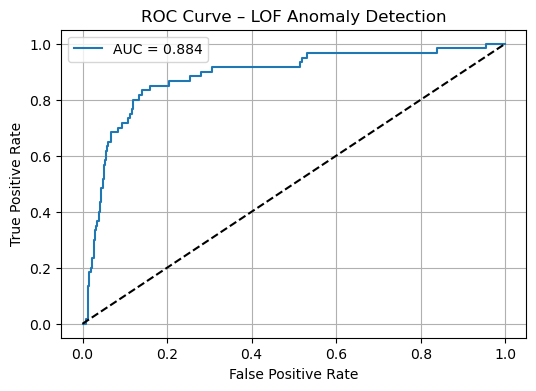

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_known = np.zeros(len(scores_k))
y_anom  = np.ones(len(scores_a))

y_all   = np.concatenate([y_known, y_anom])
s_all   = np.concatenate([scores_k, scores_a])

fpr, tpr, thr = roc_curve(y_all, s_all)   
roc_auc = auc(fpr, tpr)

print("Anomaly AUC:", roc_auc)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LOF Anomaly Detection")
plt.legend()
plt.grid(True)
plt.show()
